In [1]:
#using package ml ml 

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import numpy as np

from sklearn import decomposition
import pandas as pd

In [2]:
from torchmetrics.functional import pairwise_cosine_similarity

In [3]:
from sklearn.decomposition import PCA

In [4]:
with open('adj/english-adjectives.txt') as f:
    adjatives = [line.strip() for line in f]

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

#from scipy import cosine

In [6]:
# import parrot

In [7]:
# par = parrot(model_tag="prithivida/parrot_paraphraser_on_T5")

In [8]:
# {'Q22.2': 'I like the idea of safe automated vehicles if they make it easier for me to travel.',
#  'Q22.3': 'I trust automated vehicles to operate safely.',
#  'Q22.4': 'I would consider buying an automated vehicle.',
#  'Q22.5': 'I would be comfortable riding in an automated vehicle.',
#  'Q22.6': 'I would allow my children to be transported in an automated vehicle.',
#  'Q22.7': 'I would pay a higher price for a partly or fully automated vehicle than a non-automated vehicle.',
#  'Q22.8': 'I would enjoy being able to use my time in an automated vehicle for things like reading, or relaxing rather than driving.',
#  'Q22.9': 'I enjoy actually driving a car, and would prefer that to riding in an automated vehicle.'}

In [9]:
num_pca = 40
scen = 0
embed_dim = num_pca
removed_quest = ['Q20.2', 'Q21.2', 'Q22.2']

pca = decomposition.PCA(n_components=embed_dim)

In [10]:
compress_method = "PCA" 
# none
# PCA
# auto_encoder
NN_PARAM = [100, 10] # last number 
lamb = 5
# parrot

In [11]:
USE_MANUAL = False

In [12]:
pca = PCA(n_components=num_pca)

In [13]:
def load_sentences(doc_name="sentences.txt"):
    file = open(doc_name, 'r')
    lines = file.readlines()
    
    ret_dic = {}
    for index, line in enumerate(lines):
        if index%2 == 0:
            key= line.strip()
        else:
            ret_dic[key] = line.strip()
    
    return ret_dic

sentences =load_sentences()
question_num = list(sentences.keys())[:-1]

def load_sentences_excel(doc_name="manual_values.xlsx", subset = 0):
    if subset == 0:
        sheet_name = "raw_questions"
    else:
        sheet_name = f"subset_{subset}"
        
    df = pd.read_excel("manual_values.xlsx", sheet_name=sheet_name)
    
    return dict(list(zip(df["Question"], df["Sentence"]))), df
# sentences =load_sentences()
# question_num = list(sentences.keys())[:-1]

In [14]:
def list_text_to_tens(sentences):
    return torch.FloatTensor(model.encode(sentences))

adj_embed = list_text_to_tens(adjatives)

In [15]:
def proces_sent(sent_dic, NUM_PEOPLE, get_strange_quest=7):
    #assume reponses are ordered 1 per person
    
    sentences = []
    questions = []
    for key, sentence in sent_dic.items():
        questions.append(key)
        sentences.append(sentence)
    
    sent_embed = model.encode(sentences)
    
    
    # find wierdest questions to be removed
    sent_dic_distances = []
    for base_vec, question in zip(sent_embed, sent_dic.keys()):
        distances = []
        for compare_vec in sent_embed:
            distances.append(cosine(compare_vec, base_vec))
        sent_dic_distances.append((question, sum(distances)/len(distances)))
        
    #pca.fit(sent_embed)
    #red_embed = pca.transform(sent_embed)
    sorted_sent_dic_distances = sorted(sent_dic_distances, key=lambda x: x[1])
    bad_questions = [quest for quest, _ in sorted_sent_dic_distances][-get_strange_quest:]
    
    ret_tens = torch.FloatTensor(sent_embed)
    return torch.concat([ret_tens for _ in range(NUM_PEOPLE)]), bad_questions


In [16]:
# foo = dict([a for a in enumerate(adjatives)])

# measurements, _ = proces_sent(foo, 1 ,0)

In [17]:
# measurements.shape

In [18]:
def load_responses(questions, filepath = "responses.xlsx"):
    df = pd.read_excel(filepath, sheet_name="Mobility and Future Mobility CL")
    df = df[questions]
    df = df.replace(["Strongly disagree", "Disagree", "Somewhat disagree", "Somewhat agree", "Agree", "Strongly agree"], 
                    [0, 1, 2, 3, 4, 5])
    
    #df = df.replace([0,1,2,3,4,5], [0,0,0,1,1,1])
    # TODO investigate NANS
    df = df.fillna(0)
    return df


In [19]:
def proces_responses(responses):
    ret_tens = responses.to_numpy()
    x, y = ret_tens.shape
    ret_tens = ret_tens.reshape(x*y)
    
    #everyone at least strongly disagrees
    disagree = 1.*(ret_tens >= .5).reshape(len(ret_tens), 1)
    som_disagree = 1.*(ret_tens >=1.5).reshape(len(ret_tens), 1)
    som_agree = 1.*(ret_tens >=2.5).reshape(len(ret_tens), 1)
    agree = 1.*(ret_tens >=3.5).reshape(len(ret_tens), 1)
    stong_agree = 1.*(ret_tens >= 4.5).reshape(len(ret_tens), 1)
    
    ret_likard = np.concatenate((disagree, som_disagree, som_agree, agree, stong_agree), axis=1)
    
    #TODO process into hot 1 embedding 
    return x, torch.FloatTensor(ret_likard)

In [20]:
def encode_sentence(in_string):
    x = model.encode(in_string)
    return x

In [21]:
from math import floor

def get_people_one_hot():
    num_q = int(len(y_train)/NUM_PEOPLE)
    to_tens = []

    for index in range(len(x_train)):
        one_hot = floor(index/num_q)
        temp_list = [0. for i in range(NUM_PEOPLE)]
        temp_list[one_hot] = 1.
        to_tens.append(temp_list)
    
    return torch.tensor(to_tens)

In [22]:
# list(questions.keys()).index(['Q22.2', 'Q22.3'])

In [23]:
def remove_quest(rem_questions, data_set):
    indexes_to_be_rem = [list(questions.keys()).index(key) for key in rem_questions]
    
    remain_quest = [index for index in range(len(data_set)) if index%len(questions) not in indexes_to_be_rem]
    removed_quest = [index for index in range(len(data_set)) if index%len(questions) in indexes_to_be_rem]
    
    remain_data_set = data_set[remain_quest]
    removed_data_set = data_set[removed_quest]
    
    return remain_data_set, removed_data_set
    

In [24]:
def get_manual_embed(df):
    return df.iloc[:, 2:].to_numpy()

def get_manual_embed_for_training(df, x_train):
    data = get_manual_embed(df)
    
    if data.shape[0] * NUM_PEOPLE == x_train.shape[0]:
        to_be_concat = [torch.tensor(data.copy()).type(torch.float32) for _ in range(NUM_PEOPLE)]
    
    return torch.concat(to_be_concat)


In [25]:
def get_person_and_responses(data, one_hot_people, person_ID):
    # used for taking the average of the persons responses
    persons_questions = one_hot_people[:, person_ID] >= 0.5
    
    return data[persons_questions].sum(axis=1)
    


In [26]:
#load quesitions
questions, df = load_sentences_excel(subset=scen)

quest_subset = questions.keys()

#load responses
responses = load_responses(quest_subset)


#process everything
NUM_PEOPLE, y_train = proces_responses(responses)

x_train, bad_questions = proces_sent(questions, NUM_PEOPLE, get_strange_quest=5)

one_hot_people = get_people_one_hot()

if USE_MANUAL:
    manual_embed = get_manual_embed_for_training(df, x_train)
    x_train = manual_embed

x_all = x_train
y_all = y_train
one_hot_all = one_hot_people
# remove given questions
x_train, x_test = remove_quest(removed_quest, x_train)
y_train, y_test = remove_quest(removed_quest, y_train)
one_hot_people, one_hot_people_test = remove_quest(removed_quest, one_hot_people)

In [27]:
NUM_PEOPLE

927

In [28]:
8*927

7416

In [29]:
x_train.shape

torch.Size([37080, 768])

In [30]:
x_train.shape

torch.Size([37080, 768])

In [31]:
x_test.shape

torch.Size([2781, 768])

In [32]:
y_train.shape

torch.Size([37080, 5])

In [33]:
y_test.shape

torch.Size([2781, 5])

In [34]:
class Logit(torch.nn.Module):
    """
    Logit model between two options 
    """
    def __init__(self, input_size, num_people=927, dim_var=1):
        super(Logit, self).__init__()
        self.num_people = num_people
        
        if compress_method == "auto_encoder" or compress_method == "parrot":
            self.input_size = NN_PARAM[-1]
        elif compress_method == "PCA":
            self.input_size = num_pca
        elif compress_method == "cosine_words":
            self.input_size = len(adj_embed)
        else:
            self.input_size = input_size
        
        self.has_fit_pca = False
        
        self.embedd_weights = torch.nn.Parameter(torch.rand(self.input_size, 1))
        self.bias = torch.nn.Parameter(torch.rand(1,1))
    
        self.person_het_vector = torch.nn.Parameter(torch.rand(num_people, dim_var))
        self.het_dimension = torch.nn.Parameter(torch.rand(dim_var, self.input_size))
        
        #self.util_to_likert = torch.nn.Linear(1, 5)
        self.likert = torch.nn.Parameter(torch.rand(1, 5))
        
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        
        # create an encoding nn network
        if compress_method == "auto_encoder" or compress_method == "parrot":
            #initialise hidden layers 
            self.encoder = torch.nn.ModuleList()
            prev_layer = input_size
            for layer_size in NN_PARAM:
                self.encoder.append(torch.nn.Linear(prev_layer, layer_size))
                prev_layer = layer_size
    
    def forward(self, chosen_options, pers_respond, floating_likart=False):
        
        chosen_options = self.compress_data(chosen_options, pers_respond)
        
        num_entries = chosen_options.shape[0]
        
        individ_variability = pers_respond @ self.person_het_vector
        variabilty_vecs = individ_variability @ self.het_dimension
        
        seed_values = (self.embedd_weights @ torch.ones(1, num_entries)).T
        
        variabilty_vecs = variabilty_vecs + seed_values 
        
        utility =  torch.sum((chosen_options * variabilty_vecs),  dim=1) + self.bias
        
        likart = utility.T @ torch.FloatTensor([[1,1,1,1,1]]) + torch.ones_like(utility.T) @ self.likert 
        
        likart = self.sigmoid(likart)
        # instead ->
        return likart
    
    def get_specific_activations(self, chosen_options, pers_respond, floating_likart=False):
        chosen_options = self.compress_data(chosen_options, pers_respond)
        
        num_entries = chosen_options.shape[0]
        
        individ_variability = pers_respond @ self.person_het_vector
        variabilty_vecs = individ_variability @ self.het_dimension
        
        seed_values = (self.embedd_weights @ torch.ones(1, num_entries)).T
        
        variabilty_vecs = variabilty_vecs + seed_values 
        
        return chosen_options * variabilty_vecs
    
    
    def compress_data(self, x_data, pers_respond):
        
        if compress_method == "none":
            return x_data
        elif compress_method == "PCA":
            return self.PCA(x_data, pers_respond)
        elif compress_method == "auto_encoder" or compress_method == "parrot":
            return self.auto_encoder(x_data)
        
        elif compress_method == "cosine_words":
            return self.cosine_words(x_data, pers_respond)
# none
# PCA
# auto_encoder
# parrot
    def cosine_words(self, x_data, pers_respond, compress_output=False):
        new_distances = pairwise_cosine_similarity(x_data, adj_embed)
        
        
        if compress_output:
            return PCA(new_distances, pers_respond)
        else:
            return new_distances

    def PCA(self, x_data, pers_respond):
        #if already has transform -> transform
        pers_respond
        if not self.has_fit_pca:
            single_set_of_questions = pers_respond[:,0] > 0.5
            
            fitting_space = x_data[single_set_of_questions]
            pca.fit(fitting_space)
            
            self.has_fit_pca = True
            
        return_val = pca.transform(x_data)
        return_val = torch.FloatTensor(return_val)
        return return_val
        
    
    def auto_encoder(self, x_data):
        #simple forward pass NN to pass
        for layer in self.encoder:
            x_data = self.relu(layer(x_data))
                                    
        return x_data
        
    def sentence_to_neurons(self, sentence):
        sentence = torch.tensor(encode_sentence(sentence)).reshape((1,768))
        neuron_activation = self.compress_data(sentence, None)
        
        return neuron_activation
    
    def poll_question(self, sentence):
        #polls a question with every participant in the study 
        option = torch.tensor(encode_sentence(sentence))
        sentence_option = torch.ones(self.num_people, 1) @ option.reshape((1, len(option)))
        one_hot_person = torch.eye(self.num_people)
        
        return self.forward(sentence_option, one_hot_person)
        
    def get_persons_values(self, ID):
        one_hot_person = torch.zeros(NUM_PEOPLE)
        one_hot_person[ID] = 1.
        
        individ_variability = one_hot_person @ self.person_het_vector
        variabilty_vecs = individ_variability @ self.het_dimension
        
        #print("1", variabilty_vecs)
        #print("2", self.embedd_weights)
        
        return variabilty_vecs + self.embedd_weights.T
        
    def get_individ_utility(self, sentence, ID):
        #BROKEN
        
        values = self.get_persons_values(ID)
        option = torch.tensor(encode_sentence(sentence))
        compress_data(get_individ_utility)
        #print(values.shape, option.shape)
        
        return  self.sigmoid(torch.sum((option * values),  dim=1) + self.bias)

In [35]:
x = torch.tensor([[2, 3], [3, 5], [5, 8]], dtype=torch.float32)
y = torch.tensor([[1, 0], [2, 1]], dtype=torch.float32)

print(x.shape)
print(y.shape)

torch.Size([3, 2])
torch.Size([2, 2])


In [36]:
dim_of_variability = 5

In [37]:
logit_model = Logit(input_size = x_train.shape[1], dim_var=dim_of_variability)


In [44]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(logit_model)

4881

In [38]:
optimizer = torch.optim.Adam(logit_model.parameters(), lr = 0.01)

In [39]:

BCE_crit = torch.nn.BCELoss()
def sparse_loss(y_pred, y_test, model, lamb):
    loss_criteria = BCE_crit(y_pred.squeeze(), y_test)
    
    for w in model.encoder:
        loss_criteria = loss_criteria + lamb * torch.norm(w.weight,p='fro')**2
    
    return loss_criteria
    
#criterion = torch.nn.BCELoss()
criterion = torch.nn.BCELoss()

In [40]:
lamb = 0.005

In [41]:
logit_model.eval()
y_pred = logit_model(x_train, one_hot_people)
before_train = criterion(y_pred.squeeze(), y_train)
print('Test loss before training' , before_train.item())

Test loss before training 15.592974662780762


In [42]:
perform = []
test_perform = []

In [43]:

def train_model(print_prog = False):
    # logit model 
    logit_model.train()
    epoch = 1000
    prev_test_loss = 100
    
    num_bad_steps = 8000000
    
    for epoch in range(epoch):
        optimizer.zero_grad()
        # Forward pass
        y_pred = logit_model(x_train, one_hot_people)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_train)
        # Backward pass
        loss.backward()
        optimizer.step()
        perform.append(loss.item())
        
        
        y_pred = logit_model(x_test, one_hot_people_test)
        # Compute Loss
        loss_test = criterion(y_pred.squeeze(), y_test)
        test_perform.append(loss_test.item())
        
        if prev_test_loss <= loss_test.item():
            num_bad_steps = num_bad_steps - 1
            if num_bad_steps <= 0:
                break
            
        prev_test_loss = loss_test.item()
        
        
        if print_prog and epoch%100 == 0:
            print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
            print('Epoch {}: test_loss loss: {}'.format(epoch, loss_test.item()))
            print("------------------------------------------------------")
            
    if print_prog:
        print("VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV")        
        print(f"done with training loss of:{loss.item()} \nand test loss of: {loss_test.item()}")
    
# early stop is leagal 
# -> https://datascience.stackexchange.com/questions/27561/can-the-number-of-epochs-influence-overfitting

train_model(print_prog = True)

Epoch 0: train loss: 15.592974662780762
Epoch 0: test_loss loss: 23.448707580566406
------------------------------------------------------


KeyboardInterrupt: 

(0.0, 3.0)

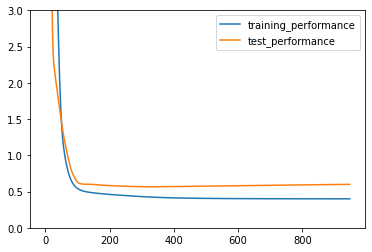

In [68]:
sns.lineplot(x=np.arange(len(perform)), y=perform, label="training_performance")
plt.plot(np.arange(len(test_perform)), test_perform, label="test_performance")
plt.legend()
plt.ylim(0, 3)

# Check Model Works

In [69]:
y_pred = logit_model(x_test, one_hot_people_test)

In [70]:
y_test

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [71]:
y_pred

tensor([[0.9492, 0.8691, 0.7315, 0.3705, 0.0926],
        [0.9690, 0.9172, 0.8198, 0.4956, 0.1455],
        [0.9252, 0.8146, 0.6432, 0.2803, 0.0632],
        ...,
        [0.9421, 0.8525, 0.7035, 0.3389, 0.0816],
        [0.9195, 0.8021, 0.6246, 0.2644, 0.0586],
        [0.6303, 0.3771, 0.1990, 0.0509, 0.0092]], grad_fn=<SigmoidBackward0>)

# Model Performance

In [72]:
from sklearn import metrics

In [73]:
def tens_to_int(y_vals):
    ret_val = y_vals >= 0.5
    return ret_val.sum(axis=1)
    

def int_to_lik(y_vals):
    ret_vals = y_vals.detach().numpy()
    
    for index, likard in enumerate(["Strongly disagree", "Disagree", "Somewhat disagree", "Somewhat agree", "Agree", "Strongly agree"]):
        #np.where(ret_vals == index, )
        1
    return 1
    
#int_to_lik(tens_to_int(y_test))

In [74]:
questions

{'Q16.2': 'It is easy for me to travel to and from public transport (e.g. stops/stations are close by or have parking or good access via footpaths/bike paths).',
 'Q16.3': 'I would cycle more if I had an e-bike (electric bike) which reduces the physical effort required.',
 'Q16.4': 'I would cycle more if I could hire a normal or e-bike near my key origin and destinations.',
 'Q16.5': 'I am happy to change modes a few times during my journey – e.g. from a bus to a train, or car to bus.',
 'Q16.6': 'I am happy to walk a short distance (up to 10 minutes) to reach my transport.',
 'Q16.7': 'I would use public transport more if it picked me up and dropped me off right near the start and end of my trip (less than 2 minute walk).',
 'Q17.2': 'I would use a shared taxi or shuttle bus if it was cheaper than taking a private taxi.',
 'Q17.3': 'I would consider not owning a car if I could access a vehicle for a comparable or lower cost in other ways when I really need it i.e. Car hire/sharing',
 

In [77]:
import plotly.graph_objects as go
from matplotlib.pyplot import figure
import scipy

def get_performance(model, question, print_conf_mat = True):
    y_pred = model(x_all, one_hot_all)
    
    #fig = make_subplots(rows=rows, cols=col)
    
    _, quest_pred = remove_quest([question], y_pred)
    _, quest_response = remove_quest([question], y_all)
    
#     # build 1 way 
#     scen=['Agreed With Prompt', 'Disagreed With Prompt']

#     response_y = quest_response > 0.5
#     model_y = quest_pred > 0.5

#     #given the model predicted y:
#     response_where_model_pred_y = response_y[model_y]

#     prob_y_given_mod_y = sum(response_where_model_pred_y)/(len(response_where_model_pred_y))
#     prob_n_given_mod_y = sum(~response_where_model_pred_y)/(len(response_where_model_pred_y))
#     print("given predicted Y, model response of YN: ", prob_y_given_mod_y, prob_n_given_mod_y)

#     response_where_model_pred_n = response_y[~model_y]
#     prob_y_given_mod_n = sum(response_where_model_pred_n)/(len(response_where_model_pred_n))
#     prob_n_given_mod_n = sum(~response_where_model_pred_n)/(len(response_where_model_pred_n))
#    print("given predicted N, model response of YN: ", prob_y_given_mod_n, prob_n_given_mod_n)
    
    predictions = tens_to_int(quest_pred)
    responses = tens_to_int(quest_response)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(predictions, responses)
    average_diff = sum((predictions - responses)**2)/len(predictions)
    
    
    scen=["Strongly\ndisagree", "Disagree", "Somewhat\ndisagree", "Somewhat\nagree", "Agree", "Strongly\nagree"]
#     fig = go.Figure(data=[
#         go.Bar(name='Model Predicts Agree', x=scen, y=[prob_y_given_mod_y, prob_n_given_mod_y]),
#         go.Bar(name='Model Predicts Disagree', x=scen, y=[prob_y_given_mod_n, prob_n_given_mod_n])
#     ])
    
#     # Change the bar mode
#     fig.update_layout(barmode='group')
#     fig.show()
    if print_conf_mat:
        print(question, ": ", questions[question])
        print(f"slope={slope:.2f}    r={r_value:.2f}    diff={float(average_diff):.2f}")
        confusion_matrix = metrics.confusion_matrix(responses, predictions)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = scen)

        fig, ax = plt.subplots(figsize=(8,8))
        cm_display.plot(ax=ax)
        plt.title(f"slope={slope:.2f}    r={r_value:.2f}    diff={float(average_diff):.2f}")
        plt.show()

    return slope, r_value, float(average_diff) 
        

In [78]:
def predictions_from_average(question, print_conf_mat = True):
    _, quest_response = remove_quest([question], y_all)
    responses_of_question = tens_to_int(quest_response)
    
    
    train_averages = []
    for i in range(NUM_PEOPLE):
        train_respons = get_person_and_responses(y_train, one_hot_people, i)
        train_averages.append(round(float(sum(train_respons)/len(train_respons))))
    
    train_averages = np.array(train_averages)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(train_averages, responses_of_question)
    
    average_diff = sum((train_averages - responses_of_question.numpy())**2)/len(train_averages)
    if print_conf_mat:
        print(f"slope={slope:.2f}    r={r_value:.2f}    diff={float(average_diff):.2f}")
        scen=["Strongly\ndisagree", "Disagree", "Somewhat\ndisagree", "Somewhat\nagree", "Agree", "Strongly\nagree"]
        confusion_matrix = metrics.confusion_matrix(responses_of_question, train_averages)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = scen)
        fig, ax = plt.subplots(figsize=(8,8))
        cm_display.plot(ax=ax)
        plt.title(f"slope={slope:.2f}    r={r_value:.2f}    diff={float(average_diff):.2f}")
        plt.show()
    return slope, r_value, average_diff


In [79]:
from tqdm import tqdm

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:46<00:00,  1.08s/it]

Test Set


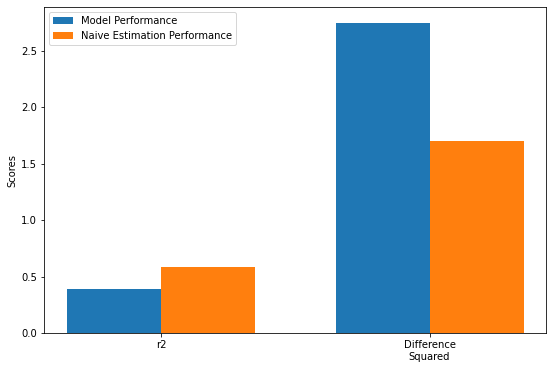

Training Set


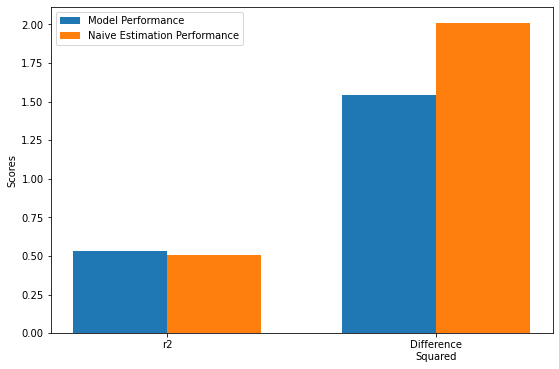

Question 22


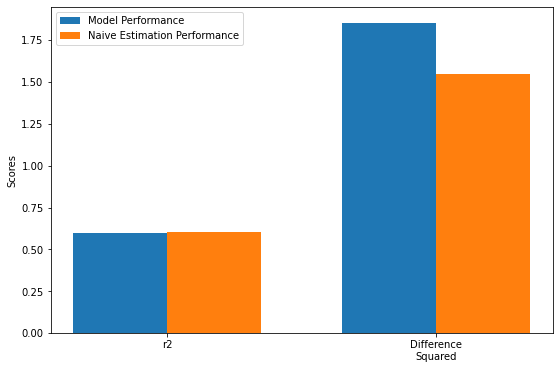

In [80]:
def get_average(list_dict, key):
    rel_list = [x[key] for x in list_dict]
    return sum(rel_list)/len(rel_list)

def get_all_performance():
    test_diff = []
    train_diff = []
    test_r2 = []
    train_r2 = []
    for quest in tqdm(questions.keys()):
        _, av_r2, av_diff = predictions_from_average(quest, False)
        _, md_r2, md_diff = get_performance(logit_model, quest, False)
        if quest in removed_quest:
            test_diff.append({"Question": quest, "Model": md_diff, "Average": av_diff})
            test_r2.append({"Question": quest, "Model": md_r2, "Average": av_r2})
            if quest == "Q22.2":
                Q22_av_r2 = av_r2
                Q22_av_diff = av_diff
                Q22_md_r2 = md_r2
                Q22_md_diff = md_diff
        else:
            train_diff.append({"Question": quest, "Model": md_diff, "Average": av_diff})
            train_r2.append({"Question": quest, "Model": md_r2, "Average": av_r2})
            
    
    print("Test Set")
    labels = ['r2', 'Difference\nSquared']
    model = [get_average(test_r2, "Model"), get_average(test_diff, "Model")]
    baseline = [get_average(test_r2, "Average"), get_average(test_diff, "Average")]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(9,6))
    rects1 = ax.bar(x - width/2, model, width, label='Model Performance')
    rects2 = ax.bar(x + width/2, baseline, width, label='Naive Estimation Performance')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_xticks(x, labels)
    ax.legend()

#     ax.bar_label(rects1, padding=3)
#     ax.bar_label(rects2, padding=3)

    plt.show()
    
    print("Training Set")
    labels = ['r2', 'Difference\nSquared']
    model = [get_average(train_r2, "Model"), get_average(train_diff, "Model")]
    baseline = [get_average(train_r2, "Average"), get_average(train_diff, "Average")]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(9,6))
    rects1 = ax.bar(x - width/2, model, width, label='Model Performance')
    rects2 = ax.bar(x + width/2, baseline, width, label='Naive Estimation Performance')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_xticks(x, labels)
    ax.legend()
    
#     ax.bar_label(rects1, padding=5)
#     ax.bar_label(rects2, padding=5)
    plt.show()
    
    
    print("Question 22")
    labels = ['r2', 'Difference\nSquared']
    model = [Q22_md_r2, Q22_md_diff]
    baseline = [Q22_av_r2, Q22_av_diff]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(9,6))
    rects1 = ax.bar(x - width/2, model, width, label='Model Performance')
    rects2 = ax.bar(x + width/2, baseline, width, label='Naive Estimation Performance')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_xticks(x, labels)
    ax.legend()

#     ax.bar_label(rects1, padding=3)
#     ax.bar_label(rects2, padding=3)
    plt.show()
get_all_performance()

Q19.5 :  I would be willing to pay between $600 and $1200 a month for a luxury car subscription with all vehicle costs covered (excluding fuel).
slope=0.86    r=0.51    diff=1.11


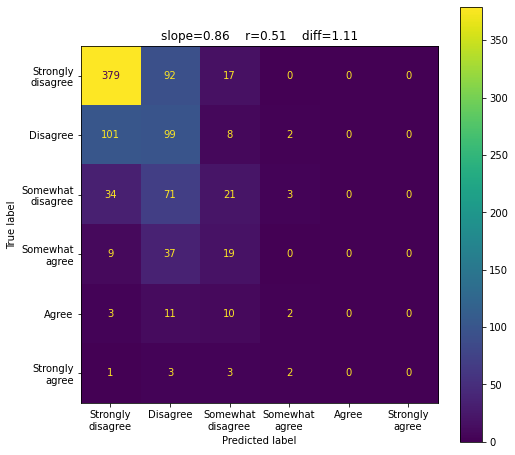

slope=0.63    r=0.47    diff=3.39


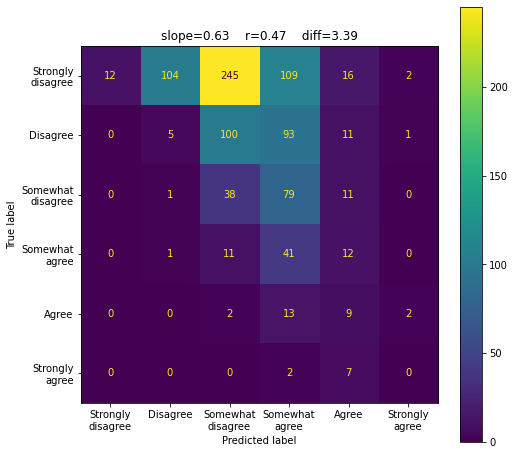

In [81]:
_ = get_performance(logit_model, "Q19.5")
_ = predictions_from_average("Q19.5")

Q22.2 :  I like the idea of safe automated vehicles if they make it easier for me to travel.
slope=0.86    r=0.60    diff=1.86


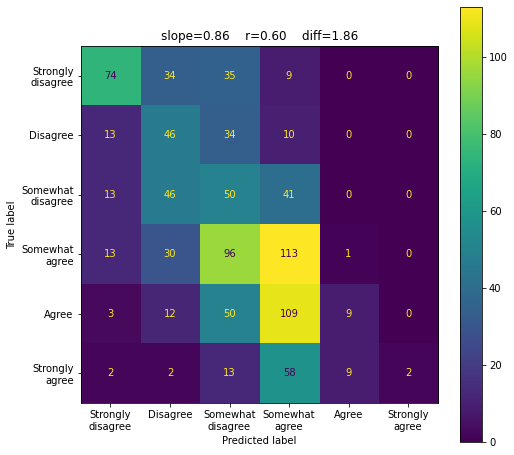

slope=1.10    r=0.61    diff=1.55


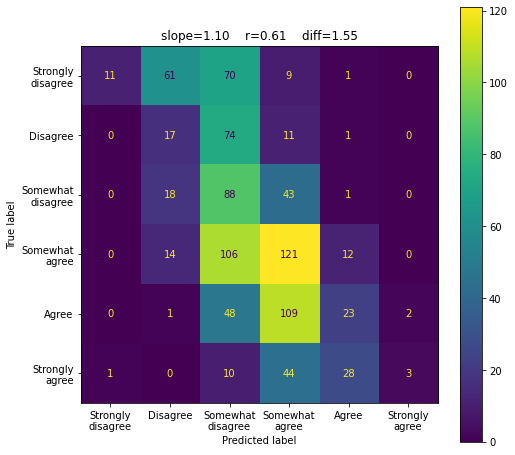

In [82]:
_ = get_performance(logit_model, "Q22.2")
_ = predictions_from_average("Q22.2")

Q21.2 :  I support electric vehicles because they are better for the environment.
slope=0.76    r=0.55    diff=1.81


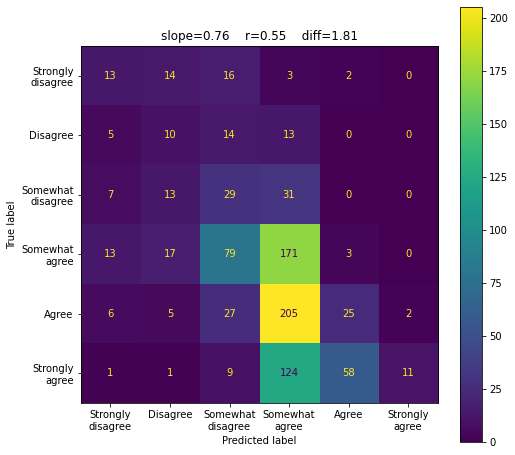

slope=0.81    r=0.52    diff=2.34


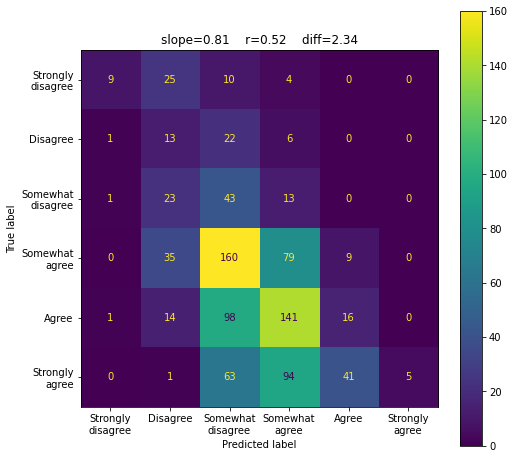

In [83]:
_ = get_performance(logit_model, "Q21.2")
_ = predictions_from_average("Q21.2")

# Neuron Examination

In [58]:
with open('adj/english-adjectives.txt') as f:
    adjatives = [line.strip() for line in f]

In [59]:
a = list(logit_model.sentence_to_neurons("slow").detach().numpy())[0]

In [60]:
adj = pd.DataFrame.from_dict({"adj": adjatives})
for nur_num, nur_act in enumerate(a):
    adj[nur_num] = np.NAN
    
adj = adj.set_index("adj")

In [61]:
adj.loc["abandoned"] = a

In [62]:
adj.loc["abandoned", 0]

5.164455890655518

In [63]:
from tqdm import tqdm

In [64]:
#list(logit_model.sentence_to_neurons("word").detach().numpy())[0]

In [65]:
a = list(logit_model.sentence_to_neurons("slow").detach().numpy())[0]

for word in tqdm(adjatives):
    neurons = list(logit_model.sentence_to_neurons(word).detach().numpy())[0]
    
    for index, n_weight in enumerate(neurons):
        adj.loc[word, index] = n_weight
    
    
    


 43%|██████████████████████████████████▎                                            | 584/1347 [00:45<00:59, 12.73it/s]


KeyboardInterrupt: 

In [ ]:
adj[2].sort_values()

In [ ]:
# person activations
personal_activations = logit_model.get_specific_activations(x_all, one_hot_all)

In [ ]:
#fit neurons to questions
interpretter = PCA(n_components=40)
interpretter.fit(x_all)

In [ ]:
adj_dict = dict(list(enumerate(adjatives)))

In [ ]:
adj_embeds, _ = proces_sent(adj_dict, int(NUM_PEOPLE/3), get_strange_quest=0)

In [ ]:
adj_embeds.shape
NUM_ROWS = int(2679030/3)
adj_embed_short = adj_embeds[:NUM_ROWS]

In [ ]:
2679030/3

In [ ]:
#usual function for this broke, make a new one that doesnt run out of memory
to_be_concat = []
np_height = len(adj_dict)
for i in range(int(NUM_PEOPLE/3)):
    temp_array = torch.zeros((np_height, NUM_PEOPLE))
    temp_array[:, i] = 1
    to_be_concat.append(temp_array)
    
one_hot_adj = torch.concat(to_be_concat)

In [ ]:
activations = logit_model.get_specific_activations(adj_embed_short, one_hot_adj)

In [ ]:
#re orent activations into orthogonal dimensions
activation_interpreter = PCA(n_components=35)
activation_interpreter.fit(activations.detach().numpy())
re_oriented_act = activation_interpreter.transform(activations.detach().numpy())

# average each word:
to_be_concat = []
for index, word in adj_dict.items():
    import_indexes = list(range(index, len(activations), len(adj_dict)))
    
    to_be_concat.append(np.sum(re_oriented_act[import_indexes], axis=0).reshape(1, -1))
average_for_word = np.concatenate(to_be_concat)


In [ ]:
# look at the words that maximise each activation
to_be_df = {"word": adj_dict.values()}
for i in range(35):
    to_be_df[i] = average_for_word[:, i]
    

In [ ]:
adj_act_2 = pd.DataFrame.from_dict(to_be_df).set_index("word")

In [ ]:
index=2
print(adj_act_2[index].sort_values().head(10))
print(adj_act_2[index].sort_values().tail(10))

In [ ]:
logit_mod

In [ ]:
len(adj_dict)

In [ ]:
average_for_word.shape

In [ ]:
# groupe questions 



In [ ]:
50/2.5*3.6

In [ ]:
temp_array.shape[0] * NUM_PEOPLE

In [ ]:
adj_embeds.shape

In [ ]:
a = 75+72+65+50
a/4
3600*4/20
8*4/100

In [ ]:
2679030 / 39861

In [ ]:
interpretter.transform(x_all)

questions


In [ ]:
# TODO
# auto confusion matrix (for scenario)

# ordered logit model

# extract actual values (language model backwards)

# kick out covariances with people socieal data
#     - IE men care about speed
#     - rich people care about status


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Model Predicts Agree", "Model Predicts Disagree", "Survey Agrees", "Survey Disagrees"],
      color = "blue"
    ),
    link = dict(
      source = [0, 0, 1, 1], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 2, 3],
      value = [8, 4, 2, 8]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
#questions

In [ ]:
removed_quest

In [ ]:

_, working_sample = remove_quest("Q22.4", y_all)
_, broken_sample = remove_quest(removed_quest, y_all)

working_sample = working_sample[:100]
broken_sample = broken_sample[:100]

In [ ]:
working_sample

In [ ]:
num_sample_people = 100
sent_to_model = 'I would consider buying an automated vehicle.'
sent_to_model = 'I trust automated vehicles to operate safely.'
sent_to_model = 'I would consider buying a vehicle.'# (0.7697223874366013)
sent_to_model = 'I trust buying an automated vehicle.' #(-0.705674437480165)
sent_to_model = 'never gonna give you up'# -0.6907486661293478
sent_to_model ='I trust automated vehicles to operate safely.'
new_pred = [float(logit_model.get_individ_utility(sent_to_model, ID)[0,0]) for ID in range(num_sample_people)]

new_pred = np.array(new_pred)

In [ ]:
import scipy

print(scipy.stats.pearsonr(working_sample, new_pred))
print(scipy.stats.pearsonr(broken_sample, new_pred))


$$ $$
$$ $$$$ $$$$ $$$$ $$$$ $$$$ $$$$ $$$$ $$$$ $$

# Out of bound Question

In [ ]:
# 2 random guys on the internet is better then 1

# is it overfitting
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(logit_model)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, logit_model.parameters())
sum([np.prod(p.size()) for p in model_parameters])


In [ ]:
len(x_train)

In [ ]:
print(removed_quest)
_, reomved_quest_results = remove_quest(removed_quest, y_all)

In [ ]:
questions.keys()

In [ ]:
y = logit_model.poll_question(questions['Q16.2']).detach().numpy()
x = reomved_quest_results

import scipy

print(scipy.stats.pearsonr(x, y))

def jitter(values):
    return values + np.random.normal(0,0.05,values.shape)

sns.scatterplot(x=jitter(x), y=jitter(y))

# dont redo PCA - fix 

In [ ]:
unkown_sent = questions[removed_quest]
print(unkown_sent)
logit_model.get_individ_utility(unkown_sent, 8)

In [ ]:
from tqdm import tqdm
#new_pred = [logit_model.get_individ_utility(unkown_sent, ID) for ID in tqdm(range(NUM_PEOPLE))]

In [ ]:
y_pred = logit_model(x_test, one_hot_people_test)
y_pred = y_pred.detach().numpy()

In [ ]:
len(y_test)
len(y_pred)

In [ ]:
print(sum(y_test))
print(sum(y_pred >= 0.5))

In [ ]:
def jitter(values):
    return values + np.random.normal(0,0.05,values.shape)
sns.scatterplot(x=jitter(y_test), y=jitter(y_pred))

In [ ]:
len(y_test) - sum(y_test)

In [ ]:
# import random 

# rand_list = [0]*591 + [1]*336
# random.shuffle(rand_list)
# rand_list = np.array(rand_list)

# pool_1 = y_pred[rand_list==1]
# pool_2 = y_pred[rand_list==0]

In [ ]:
pool_1 = y_pred[y_test==1]
pool_2 = y_pred[y_test==0]

In [ ]:
from scipy import stats

t_value,p_value=stats.ttest_ind(pool_1, pool_2)
p_value

In [ ]:
import scipy

scipy.stats.pearsonr(y_test, y_pred)

In [ ]:
sum(pool_1)/len(pool_1)

In [ ]:
sum(pool_2)/len(pool_2)

In [ ]:
a = torch.nn.Linear(1,6)


In [ ]:
a(torch.FloatTensor([0.5]))